# Применение различных оптимизаторов `PennyLane` для решения одномерных и многомерных задач
Мы рассмотрим существующие в `PennyLane` оптимизаторы на основе градиентного спуска и специализированных квантовых методов оптимизации. В качестве тестовой задачи будем рассматривать уже знакомую нам задачу поиска угла поворота кубита. В программе:
- Знакомство с основными оптимизаторами `PennyLane`
- Построение корректной функции использования оптимизаторов
- Подбор параметров оптимизаторов
- Зависимость от начальной точки

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from time import perf_counter

import pennylane as qml
from pennylane import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, IBMQ
from qiskit.circuit import Parameter

# deprecated, vpn is needed: Loading your IBM Q account(s)
# provider = IBMQ.load_account()
dev = qml.device('qiskit.aer', wires=2, backend='qasm_simulator', shots=1024)

mpl.rcParams['figure.dpi'] = 150

# Что будем оптимизировать?
Генерируем состояние Белла $|\Phi+\rangle$ и действуем на первый кубит оператором $R_y$ с заранее заданным углом поворота. Также построим `disentangler` на основе нашего предположения о том, что параметром схемы является угол поворота первого кубита.

C:\Users\vonGostev\AppData\Local\Temp\ipykernel_12888\1614247038.py:27: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  (circuit_prep_qsk+circuit_meas_qsk).draw('mpl')


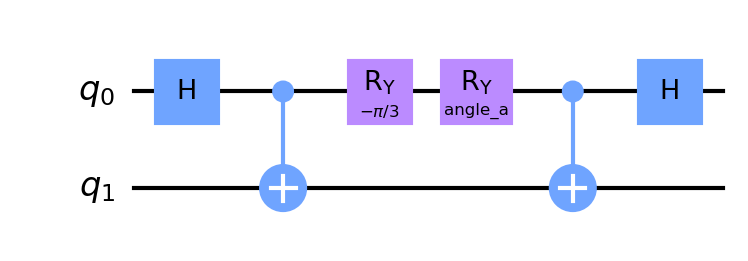

In [5]:
rotation_angle = - np.pi / 3
circuit_prep_qsk = QuantumCircuit(2)
circuit_prep_qsk.h(0)
circuit_prep_qsk.cx(0, 1)
circuit_prep_qsk.ry(rotation_angle, 0)
#circuit_prep_qsk.barrier([0,1])

circuit_prep = qml.from_qiskit(circuit_prep_qsk)

angle_a = Parameter("angle_a")
circuit_meas_qsk = QuantumCircuit(2)
circuit_meas_qsk.ry(angle_a, 0)
circuit_meas_qsk.cnot(0, 1)
circuit_meas_qsk.h(0)

circuit_meas = qml.from_qiskit(circuit_meas_qsk)

@qml.qnode(dev)
def bell_state_meas(angles):
    circuit_prep(wires=[0,1])
    circuit_meas({angle_a: angles[0]})#, angle_b: angles[1]})
    return qml.expval(qml.PauliZ(0))

def cost(angles):
    return -bell_state_meas(angles)

(circuit_prep_qsk+circuit_meas_qsk).draw('mpl')

### Как оптимизировать?
Пишем функцию для работы с оптимизатором. 
- Останавливаться будем по приращению координат (`epsilon`, `eps`)
- Учтем возможность зацикливания и слишком высокой установленной точности и ограничим число шагов `maxiter`
- Добавим логирование

In [2]:
def optimize(
    optimizer: object, cost_function: 'function', params: np.ndarray, eps: float=1e-4, maxiter: int=100, log: bool=False, hist: bool=True):

    print(f"{type(optimizer).__name__}: Initial point is {params}")

    params_history = []
    cost_history = []

    i = 0
    diff = 1e10
    t_start = t_start0 = perf_counter()
    while True:
        params, cost = optimizer.step_and_cost(cost_function, params)
        params_history.append(params)
        cost_history.append(cost)
        i += 1

        if i > 2:
            diff = np.linalg.norm(params_history[-1] - params_history[-2], ord=2)
            if diff < eps:
                break
        
        if (i + 1) % 10 == 0 and log:
            print(f"Step {i + 1:d}, time to step {(perf_counter() - t_start) / 10:.3g} s: " +
                  f"{type(optimizer).__name__} cost={cost:.3f} angle={params[0]:.3g} (pi / {np.pi / params[0]:.3g})")
            t_start = perf_counter()
        
        if i > maxiter:
            break
    print(f"{type(optimizer).__name__}: Iteration stopped with diff = {diff:.5g} on the step {i - 1} with elapsed time {perf_counter() - t_start0:.2g} s")
    
    if hist:
        return params_history, cost_history
    else:
        return params, cost

### Оптимизируем в одномерном пространстве
- Выбираем несколько оптимизаторов
- Обсуждаем их особенности
- Прогоняем в равных и не очень условиях
- Смотрим зависимость от начального приближения
- Смотрим зависимость от параметров, как вообще выбирать параметры, что учитывать

Полезная статья про большинство оптимизационных алгоритмов урока: https://habr.com/ru/post/318970/

И еще одна статья с более знакомой нотацией: https://habr.com/ru/post/413853/

### Градиентный спуск и инерционные методы
- Градиентный спуск: $x_{k+1}=x_k-\alpha\nabla f(x_k)$
- Метод моментов: $x_{k+1}=x_k+\beta(x_k-x_{k-1})-\alpha\nabla f(x_k)$
- Метод Нестерова: $x_{k+1}=x_k+\beta(x_k-x_{k-1})-\alpha\nabla f(x_k+\beta_k(x_k-x_{k-1}))$
- Метод Adagrad: $x_{k+1}=x_k-\alpha\nabla f(x_k)/\sqrt{\sum_{i=1}^{k}\nabla f(x_i)^2+\epsilon}$
- Метод RMSProp: $x_{k+1}=x_k-\alpha\nabla f(x_k)/\sqrt{\gamma\sum_{i=1}^{k-1}\nabla f(x_i)^2+(1-\gamma)\nabla f(x_k)^2+\epsilon}$

In [22]:
optimizers = [
    qml.GradientDescentOptimizer(stepsize=0.1),
    qml.MomentumOptimizer(stepsize=0.1, momentum=0.8), 
    qml.NesterovMomentumOptimizer(stepsize=0.1, momentum=0.8),
    qml.AdagradOptimizer(stepsize=0.1, eps=1e-4),
    qml.RMSPropOptimizer(stepsize=0.1, decay=0.9, eps=1e-4),
    qml.AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.95, eps=1e-4),
    qml.SPSAOptimizer(maxiter=100, alpha=0.602, gamma=0.101, c=0.2, A=None, a=None),
]

In [177]:
data = {}
params = np.array([0])
# np.random.random_sample(1) * np.pi
for optimizer in optimizers[1:3]:
    data[type(optimizer).__name__] = optimize(optimizer, cost, params, eps=1e-4, log=True)

NesterovMomentumOptimizer: Initial point is [0]
Step 10, time to step 0.0808 s: NesterovMomentumOptimizer cost=-0.994 angle=1.16 (pi / 2.72)
Step 20, time to step 0.0818 s: NesterovMomentumOptimizer cost=-1.000 angle=1.04 (pi / 3.01)
Step 30, time to step 0.0839 s: NesterovMomentumOptimizer cost=-1.000 angle=1.04 (pi / 3.01)
Step 40, time to step 0.081 s: NesterovMomentumOptimizer cost=-1.000 angle=1.04 (pi / 3.01)
Step 50, time to step 0.082 s: NesterovMomentumOptimizer cost=-1.000 angle=1.04 (pi / 3.03)
NesterovMomentumOptimizer: Iteration stopped with diff = 5.7828e-05 on the step 51 with elapsed time 4.3 s


NesterovMomentumOptimizer: Optimal point is 1.04 (pi / 3.01)


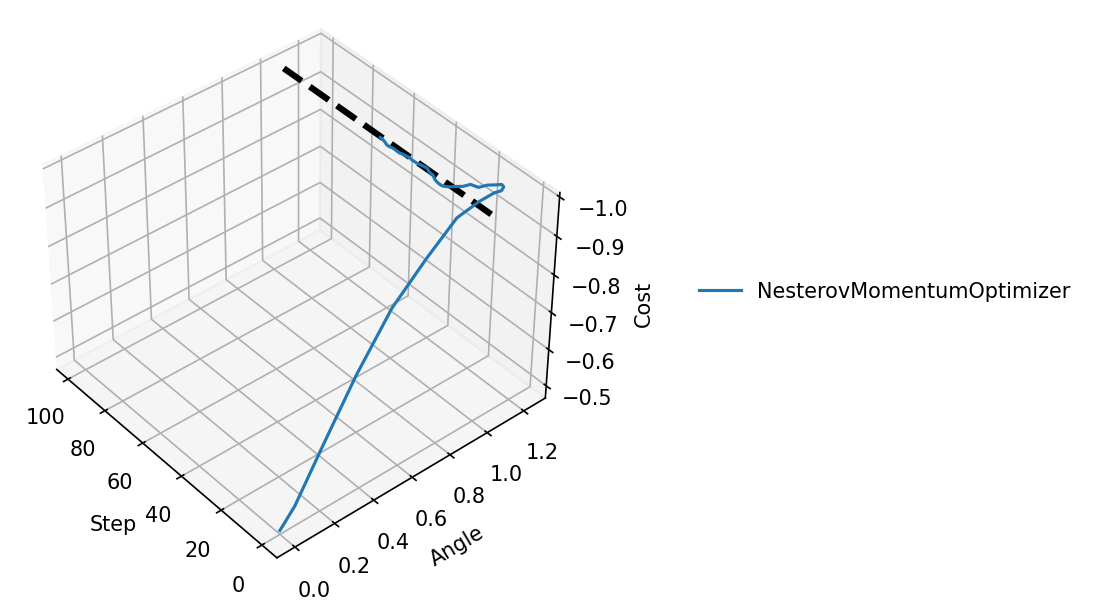

In [178]:
ax = plt.axes(projection='3d')
ax.plot3D(np.arange(100), np.ones(100) * np.pi / 3, - np.ones(100), '--', color='black', linewidth=3)
ax.view_init(-140, 40)
ax.set_xlabel('Step')
ax.set_ylabel('Angle')
ax.set_zlabel('Cost', rotation=90)

for opt in data:
    phist, chist = data[opt]
    ax.plot3D(np.arange(len(phist)), [x[0] for x in phist], chist, label=opt)
    print(f"{opt}: Optimal point is {phist[-1][0]:.3g} (pi / {np.pi / phist[-1][0]:.3g})")
plt.legend(frameon=False, bbox_to_anchor=[1.2, 0.5], loc='center left')
plt.show()

### Оптимизируем в двухмерном пространстве
- Разибраем несколько разных оптимизационных моделей: Выпуклую, невыпуклую
- Улучшение невыпуклой функции, регуляризация
  
Пример для L1-регуляризации. Поворот по Rx второго кубита дает невыпуклую функцию потерь, но с помощью регуляризации по 1-норме можно придти к правильному решению.

C:\Users\vonGostev\AppData\Local\Temp\ipykernel_12888\617785390.py:20: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  (circuit_prep_qsk+circuit_meas_qsk).draw('mpl')


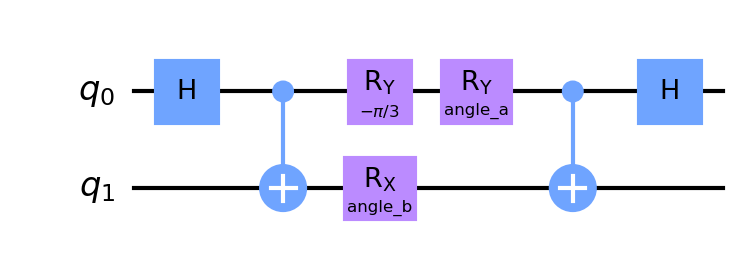

In [16]:
angle_a = Parameter("angle_a")
angle_b = Parameter("angle_b")
circuit_meas_qsk = QuantumCircuit(2)
circuit_meas_qsk.ry(angle_a, 0)
circuit_meas_qsk.rx(angle_b, 1)
circuit_meas_qsk.cnot(0, 1)
circuit_meas_qsk.h(0)

circuit_meas = qml.from_qiskit(circuit_meas_qsk)

@qml.qnode(dev)
def bell_state_meas_2d(angles):
    circuit_prep(wires=[0,1])
    circuit_meas({angle_a: angles[0], angle_b: angles[1]})
    return qml.expval(qml.PauliZ(0))

def cost_2d(angles):
    return -bell_state_meas_2d(angles) + 1e-2 * np.sum(np.abs(angles))

(circuit_prep_qsk+circuit_meas_qsk).draw('mpl')

Убедимся, что "правильная" точка является оптимальной или близкой к ней

In [8]:
cost_2d([np.pi / 3, 0])

tensor(-0.99989528, requires_grad=True)

Построим тепловую карту функции потерь

In [8]:
cost_value = lambda x, y: cost_2d([x, y])
angles = np.linspace(0, np.pi, 10)
grid = np.meshgrid(angles, angles)
cost_values = np.vectorize(cost_value)(*grid)

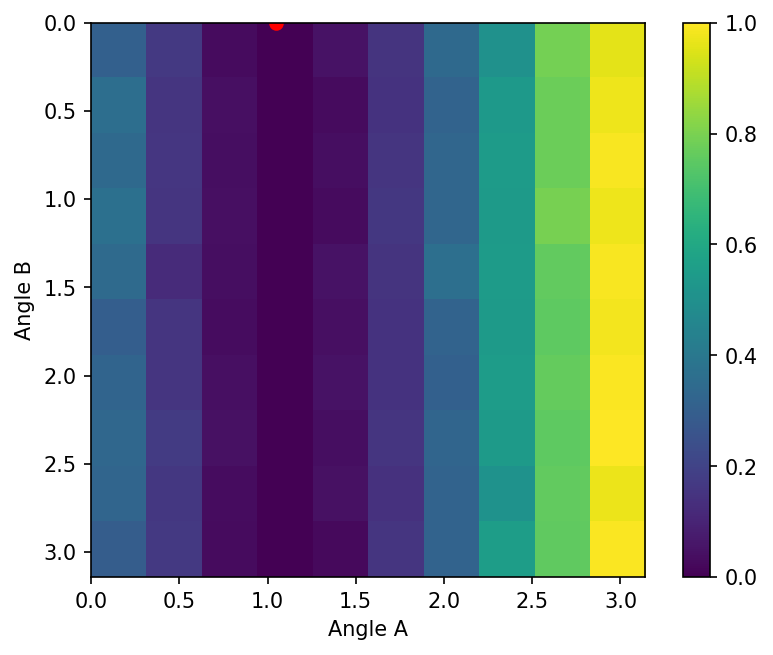

In [9]:
plt.imshow(cost_values, extent=[0, np.pi, np.pi, 0])
plt.scatter([np.pi/3], [0], color='red')
plt.xlabel("Angle A")
plt.ylabel("Angle B")
plt.colorbar()

Запустим метод градиентного спуска и моментные методы для поиска оптимального значения со случайным начальным приближением. Видно, что скорость сходимости очень сильно зависит от начального приближения.

In [23]:
# data = {}
# np.random.random_sample(1) * np.pi
params = np.array([np.pi, np.pi])
for optimizer in optimizers[5:6]:
    data[type(optimizer).__name__] = optimize(optimizer, cost_2d, params, eps=1e-4, log=False, maxiter=500)

AdamOptimizer: Initial point is [3.14159265 3.14159265]
AdamOptimizer: Iteration stopped with diff = 0.020428 on the step 500 with elapsed time 78 s


RMSPropOptimizer: Optimal point is [1.03960963 0.0315346 ]
AdamOptimizer: Optimal point is [1.06074774 0.00194467]


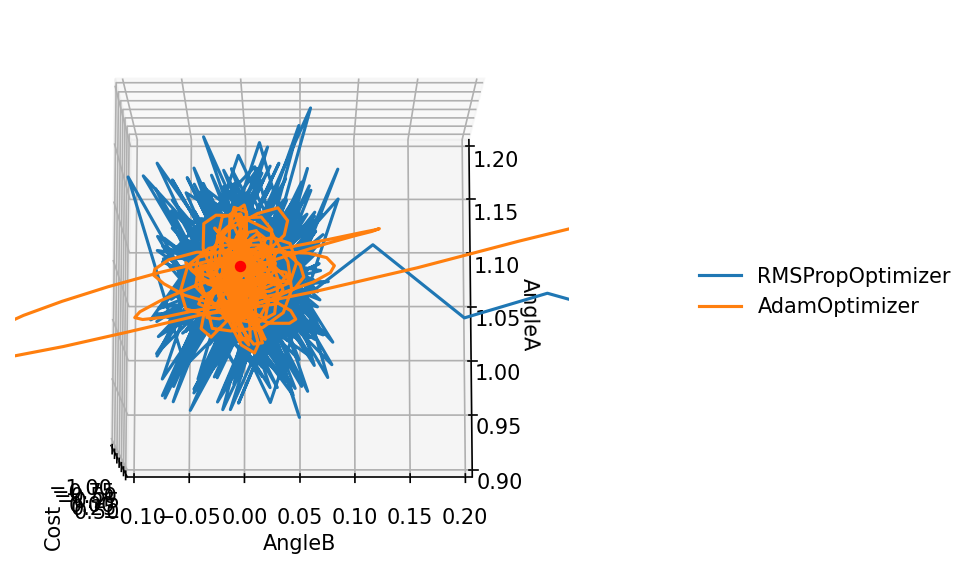

In [31]:
ax = plt.axes(projection='3d')
ax.view_init(-100, 0)
ax.set_xlabel('AngleA')
ax.set_ylabel('AngleB')
ax.set_zlabel('Cost', rotation=90)
ax.set_ylim(-0.1, 0.2)
ax.set_xlim(0.9, 1.2)
for opt in data:
    # if opt == 'RMSPropOptimizer':
    #      continue
    phist, chist = data[opt]
    phist = np.array(phist).T
    ax.plot3D(phist[0], phist[1], chist, label=opt)
    print(f"{opt}: Optimal point is {phist[:,-1]}")
ax.scatter3D([np.pi / 3], [0], [-1], color='red')

plt.legend(frameon=False, bbox_to_anchor=[1.2, 0.5], loc='center left')
plt.show()

### Домашнее задание
- Выяснить, почему оптимизация числа итераций через время выполнения не дало корректных результатов для момента в методе Нестерова

In [ ]:
def cost_momentum(momentum):
    params = np.array([0.])
    o = qml.NesterovMomentumOptimizer(stepsize=0.1, momentum=momentum)
    t = perf_counter()
    optimize(o, cost, params, eps=1e-4, log=False)
    print(perf_counter() - t)
    return perf_counter() - t

from scipy.optimize import minimize_scalar
minimize_scalar(cost_momentum, bounds=(0.5, 1))

- Выяснить, почему 1-я норма выделяет главные компоненты, зануляя остальные, а 2-я норма сглаживает пики, оставляя максимальное число компонентов ненулевыми.
- Выяснить, что делать с функцией `cost_2d`, чтобы она приводила к `правильному` решению при дизэнтанглере вида

In [ ]:
angle_a = Parameter("angle_a")
angle_b = Parameter("angle_b")
circuit_meas_qsk = QuantumCircuit(2)
circuit_meas_qsk.ry(angle_a, 0)
circuit_meas_qsk.ry(-angle_b, 1)
circuit_meas_qsk.cnot(0, 1)
circuit_meas_qsk.h(0)